### 1. 文件读取

In [5]:
import os
import numpy as np
import scipy.stats as st

import seaborn as sns

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd

filepath = '../../Data/'

pathDir =  os.listdir(filepath)
data_index = [] #所有数据集名字列表，不带路径，不带扩展名
for i in pathDir:
    if (i[i.rfind('.'):] == '.npz'):
        data_name = i[:-4]
        data_index.append(data_name)
print("There are {0} \'.npz\' file in the path!\nThey are {1}".format(len(data_index), data_index))



There are 26 '.npz' file in the path!
They are ['Aiden_GM12878_Rep2_500000', 'Aiden_IMR90_Rep2_500000', 'Aiden_K562_500000', 'BIRM_BEP2D_500000', 'BIRM_BERP35T1_500000', 'BIRM_BERP35T4_500000', 'Dekker_A549_500000', 'Dekker_CAKI2_500000', 'Dekker_G401_500000', 'Dekker_LNCaP_500000', 'Dekker_NCIH460_500000', 'Dekker_PANC1_500000', 'Dekker_RPMI7951_500000', 'Dekker_SJCRH30_500000', 'Dekker_SKMEL5_500000', 'Dekker_SKNDZ_500000', 'Dekker_SK-N-MC_500000', 'Dekker_T47D_500000', 'Farnham_22RV1_500000', 'Farnham_C42B_500000', 'Farnham_RWPE1_500000', 'Lee_RPMI8226_H_500000', 'Lee_RPMI8226_M_500000', 'Lee_U266_H_500000', 'Lee_U266_M_500000', 'RenLab_IMR90_500000']


### 2. 子函数定义

In [6]:
def in_put_npz(filepath,filename):
    file = filepath + filename + '.npz'
    data = np.load(file)
    return data

def chr_interaction_pick(data,i,j):#输入总的数据集，输出想要比对的chr_i,chr_j构成的染色体间互作矩阵
    pos,size = pre_deal_dataset(data)
    return data['hic'][pos[i]:pos[i]+size[i],pos[j]:pos[j]+size[j]]

    

def pre_deal_dataset(data):#data是load的npz数据,获得数据集中不同的染色体位置
    pos = np.zeros(25,dtype = np.int64) #对应1-22号染色体和X，Y染色体位置，最后一位是Y染色体终止位
    for i in range(1,25): #找出不同染色体区域
        if i<23:        
            pos[i-1] = np.where(data['col'] == 'chr'+str(i)+'-0')[0][0]
        else:
            if i == 23:
                pos[i-1] = np.where(data['col'] == 'chrX-0')[0][0]
            else:
                pos[i-1] = np.where(data['col'] == 'chrY-0')[0][0]
    pos[-1] = 6206 #Y终止位
    diff = np.diff(pos) #每条染色体的矩阵规模
    return pos,diff

# def get_Matrix(data,i,j):#输入总的数据集，输出想要比对的chr_i,chr_j构成的染色体间互作矩阵信号增强方阵
#     M = chr_interaction_pick(data,i,j)
#     return np.dot(M,M.T),np.dot(M.T,M)



def spectral(S,resolution_hist):#输入对称方阵、频谱细腻度分母(例如1000，表示每个hist柱子区间为1000)， 输出方阵的谱(本质是hist) 
    eigenvalue,eigenvector = np.linalg.eigh(S,UPLO='L')
#     x= eigenvalue.real
#     y= eigenvalue.imag
    z = abs(eigenvalue)[abs(eigenvalue)>0.1]
    number_Max = len(z[z>1e7])#特别大的离值点单独统计 防止bins过多影响效率
    z = z[z<=1e7]
    number_bin = np.maximum(np.int64(np.amax(z)/resolution_hist),1)
    H,bin_edges = np.histogram(z,bins=number_bin)
    return H,bin_edges,1-z[-2]/z[-1],number_Max



def write_to_csv(filepath,filename,data):#libreoffice 数据导入
    file = filepath + filename + '.csv'
    save = pandas.DataFrame(data)
    sort_save = save.sort_values(by = list(range(2,save.shape[1]),ascending=False))
    sort_save.to_csv(file)



def calcu_chr_interaction(data,i,j):# 输入总的数据集，想要对比的chr_i,chr_j，输出能量值分布 分布峰度
    M = chr_interaction_pick(data,i,j)
    cnt = 3
    while cnt>0:
        M[np.where(M==np.amax(M))] = 0
        cnt = cnt - 1
        
    X1 = np.dot(M,M.T)
    X2 = np.dot(M.T,M)
    H1,bin_edges1 = np.histogram(np.amax(X1,1),bins='auto',density = True)
    H2,bin_edges2 = np.histogram(np.amax(X2,1),bins='auto',density = True)
    energy = np.dot(H1,bin_edges1[0:-1])+np.dot(H2,bin_edges2[0:-1])
    kurt = st.kurtosis(np.amax(X1,1))+st.kurtosis(np.amax(X2,1))
    return energy,kurt

def calcu_score_trans_signal(M,resolution_hist):#输入数据集，比对的染色体的相互作用矩阵
    X = np.dot(M,M.T)
    H,bin_edges,distance,number_Max = spectral(X,resolution_hist)
    p = -1
    h = H[p:]
#     while np.amax(h)<=1:
    while len(H[H==0])>len(h[h==0]) and np.amax(h)<=1:
        p = p - 1
        h = H[p:]
    if (len(H)>1 and H[p-1]==1):
        p = p - 1
        h = H[p:]
    return len(h[h==1])+number_Max,distance    

def count_trans_signal(S):#输入方阵，获得特征值排序，分区间段统计离散大值数目
    cut = np.array([1e7,5e6,2e6,1e6,5e5,2e5,1e5,5e4,2e4,1e4])#可修改
    eigenvalue,eigenvector = np.linalg.eigh(S,UPLO='L')
    test = abs(eigenvalue)[abs(eigenvalue)>0.1]
    tmp = [len(test[test>value]) for value in cut]
    return tmp




### 3. 全部数据集计算峰度来判断极值偏离 （效果不好，假阳性、假阴性都高）

In [ ]:
for filename in data_index:
#     filename = data_index[2]
    data = in_put_npz(filepath,filename)
    print(filename)
    
    value_struct = np.dtype([('pos_i','i'),('pos_j','i'),('energy','f'),('kurt','f')])
    len_value_L = 23*24/2
    value_L = np.zeros((np.int(len_value_L),),dtype = value_struct)
    k = 0
    for i in range(0,24):
        for j in range(i+1,24):
            tmp_energy,tmp_kurt = calcu_chr_interaction(data,i,j)
#             print(i,j,tmp_ans)
            value_L[k]=(i,j,-tmp_energy,-tmp_kurt)
            k = k + 1
    print(filename,':',np.sort(value_L,order='kurt'))

    

### 4. 单数据集测试峰度、能量（效果不好）

In [ ]:
filename = data_index[2]
data = in_put_npz(filepath,filename)
print(filename)
    
energy_struct = np.dtype([('pos_i','i'),('pos_j','i'),('energy','f'),('kurt','f')])
len_energy_L = 23*24/2
energy_L = np.zeros((np.int(len_energy_L),),dtype = energy_struct)
k = 0
for i in range(0,24):
    for j in range(i+1,24):
        tmp_energy,tmp_kurt = calcu_chr_interaction(data,i,j)
        print(i,j,tmp_energy,tmp_kurt)
        energy_L[k]=(i,j,tmp_energy,tmp_kurt)
        k = k + 1
    
print(filename,':',energy_L)
    

In [ ]:
energy_struct = np.dtype([('pos_i','i'),('pos_j','i'),('energy','f')])
len_energy_L = 23*24/2
energy_L = np.zeros((np.int(len_energy_L),),dtype = energy_struct)
# for p in range(0,2):
k = 0
for i in range(0,24):
    for j in range(i+1,24):
#         tmp_ans = calcu_chr_interaction(data,i,j)
#         print(i,j,0.1)
        energy_L[k]=(i,j,0.1*k*(-1))
        k = k + 1
    #         print(k)
out = np.sort(energy_L,order='energy')
print(energy_L,out)

### 5. 单数据集测试谱密度表征易位程度(结果还行)

In [ ]:
filename = data_index[7] #CAKI dataset
# filename = data_index[17] #T47D dataset
filename = data_index[2] #K562 dataset
data = in_put_npz(filepath,filename)
print(filename)

result_struct = np.dtype([('pos_i','i'),('pos_j','i'),('count','i'),('distance','f')])
len_result = 12*23
result_L = np.zeros((len_result,),dtype = result_struct)
k = 0
for i in range(24):
    for j in range(i+1,24):
        M = chr_interaction_pick(data,i,j)
        count, distance = calcu_score_trans_signal(M,resolution_hist=1000)
        print('(%d,%d)\t%d\t%f'%(i+1,j+1,count,distance))
        result_L[k] = (i+1,j+1,count,distance)
        k = k + 1
write_to_csv(filepath,filename,result_L)

### 6.全部数据集测试谱密度表征（hist计数）

In [28]:
for filename in data_index:
#     filename = data_index[2]
    data = in_put_npz(filepath,filename)
    print(filename)

    result_struct = np.dtype([('pos_i','i'),('pos_j','i'),('count','i'),('distance','f')])
    len_result = 12*23
    result_L = np.zeros((len_result,),dtype = result_struct)
    k = 0
    for i in range(24):
        for j in range(i+1,24):
            M = chr_interaction_pick(data,i,j)
            count, distance = calcu_score_trans_signal(M,resolution_hist=1000)
#             print('(%d,%d)\t%d\t%f'%(i+1,j+1,count,distance))
            result_L[k] = (i+1,j+1,count,distance)
            k = k + 1
    write_to_csv(filepath,filename,result_L)

Aiden_GM12878_Rep2_500000
Aiden_IMR90_Rep2_500000
Aiden_K562_500000
BIRM_BEP2D_500000
BIRM_BERP35T1_500000
BIRM_BERP35T4_500000
Dekker_A549_500000
Dekker_CAKI2_500000
Dekker_G401_500000
Dekker_LNCaP_500000
Dekker_NCIH460_500000
Dekker_PANC1_500000
Dekker_RPMI7951_500000
Dekker_SJCRH30_500000
Dekker_SKMEL5_500000
Dekker_SKNDZ_500000
Dekker_SK-N-MC_500000
Dekker_T47D_500000
Farnham_22RV1_500000
Farnham_C42B_500000
Farnham_RWPE1_500000
Lee_RPMI8226_H_500000
Lee_RPMI8226_M_500000
Lee_U266_H_500000
Lee_U266_M_500000
RenLab_IMR90_500000


### 7. 单个数据集测试谱密度表征(区间段计数)

In [ ]:
filename = data_index[7] #CAKI dataset
# filename = data_index[17] #T47D dataset
# filename = data_index[2] #K562 dataset
data = in_put_npz(filepath,filename)
print(filename)

result = []

for i in range(24):
    for j in range(i+1,24):
        M = chr_interaction_pick(data,i,j)
        X = np.dot(M,M.T)
        tmp = count_trans_signal(X)
        tmp2 = [i+1,j+1] + [sum(tmp)] + tmp
        result.append(tmp2)
        
write_to_csv(filepath,filename,result)

### 8. 全部数据集测试谱密度表征(区间段计数)

### 9. 单数据集绘图（示意用）

In [ ]:
filename = data_index[7] #CAKI dataset
data = in_put_npz(filepath,filename)
i = 1
j = 5
M = chr_interaction_pick(data,i,j)

def create_eigenvector_plot_set(eig_vector):
# eig_vector = eigenvector2
    n = 5
    m = len(eig_vector)
    df_L = []
    tmp = pd.DataFrame(columns = list('12345'),data = eig_vector[:,-n:])

    df = pd.DataFrame(columns = ['bins'], data = range(m))
    for k in list('12345'):
        df_L.append(pd.DataFrame(columns = ['bins','signal'], data = {(df['bins'][i],tmp[k][i]) for i in range(m)}))
    data = pd.concat(df_L,axis=0)
    return data

eigenvalue1,eigenvector1 = np.linalg.eigh(np.dot(M,M.T),UPLO='L')
eigenvalue2,eigenvector2 = np.linalg.eigh(np.dot(M.T,M),UPLO='L')

answer1 = create_eigenvector_plot_set(eigenvector1) 
answer2 = create_eigenvector_plot_set(eigenvector2)
# print(answer)
# sns.axes_style() 输出画图参数
sns.set_context("talk")
g1 = sns.relplot(x = "bins", y = "signal", data = answer1, kind='line', linewidth=2, height = 8)
g1.set_axis_labels("bins of chr%d"%(i+1))
g1.savefig("snsplot_chr%d.png"%(i+1),dpi = 400)
g2 = sns.relplot(x = "bins", y = "signal", data = answer2, kind='line', linewidth=2, height = 8)
g2.set_axis_labels("bins of chr%d"%(j+1))
g2.savefig("snsplot_chr%d.png"%(j+1),dpi = 400)
g3 = plt.figure(figsize=(8,8))
g3.add_axes(ax)
sns.heatmap(M,cmap = 'Reds',ax = ax,cbar=False)
plt.savefig("snsheat_chr%d_chr%d.png"%(i+1,j+1),dpi=400)


# g3 = sns.heatmap(M,cmap = 'Reds')
# g3.set_axis_labels("chr%d"%(j+1),"chr%d"%(i+1))
# g3.set_titles("CAKI2细胞系")
# g3.savefig("snsheat_chr%d_chr%d.png"%(i+1,j+1),dpi=400)

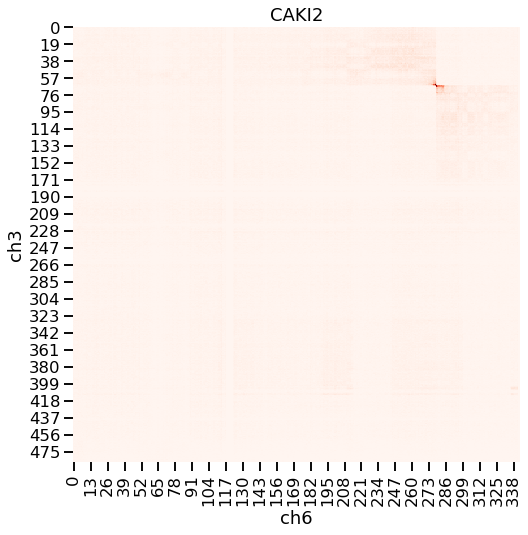

In [59]:
# g3, axs = plt.subplots(3,1,figsize = (8,24))
# i = 0
# sns.heatmap(np.dot(M,M.T),ax=axs[i],cmap = 'Reds',cbar= False)
# i = i + 1
# sns.heatmap(M,ax=axs[i],cmap = 'Reds',cbar= False)
# i = i + 1
# sns.heatmap(np.dot(M.T,M),ax=axs[i],cmap = 'Reds',cbar= False)
# plt.savefig(g3,)
# # g3.set_axis_labels("chr%d"%(j+1),"chr%d"%(i+1))
# # g3.set_titles("CAKI2细胞系")
# # g3.savefig("snsheat_chr%d_chr%d.png"%(i+1,j+1),dpi=400)

g3,axs = plt.subplots(1,1,figsize=(8,8))
# g3.add_axes(ax)
sns.heatmap(M,cmap = 'Reds',ax = axs,cbar=False)
axs.set_title("CAKI2")
axs.set_xlabel("ch%d"%(j+1))
axs.set_ylabel("ch%d"%(i+1))
plt.savefig("snsheat_chr%d_chr%d.png"%(i+1,j+1),dpi=400)